# Horizons detection challenge

*Seismic horizon* is a change in rock properties across a boundary between two layers of rock, particularly seismic velocity and density. Such changes are visible in seismic images (even for an untrained eye), and could be automatically detected.

Your task is to train a convolutional neural network that extends horizons-labelling from one part of a seismic cube to another (unseen during training) part of the same cube.

When solving the task, we highly recommend you to use [open-source framework `Seismiqb` for convenient deep learning on seismic cubes](https://github.com/gazprom-neft/seismiqb).

The notebooks starts with the description of the task at hand and the dataset. In the next section you will learn how to build and test a baseline-model to extend horizons from one part of the cube to another using [neural network UNet](https://arxiv.org/abs/1505.04597). In the last section we will give you a set of hints about improving the baseline model. We finish the notebook by the procedure that is used to prepare predictions on validation cube for the evaluation.

* [Dataset & task](dataset)
* [Training and testing baseline-model](architecture)
* [Improving and evaluating the baseline](improving)

<a id='dataset'></a>

# Dataset & task

For training and validation we use *two different parts of a seismic cube*. We will sometimes refer to different parts of a cube as *training cube* and *validation cube*. 4 hand-labeled horizons go along with each part of the cube. Needless to say, only the labelling for the training part of the cube is available to you.

<img src="images/cube_detection.jpg" alt="Drawing" style="width: 600px; height: 400px"/>

To understand why it is convenient to use `Seismiqb` for working with seismic cubes, consider the following fact: both training and validation-parts of the cube are too big to fit into the GPU memory (for instance, training part has shape **[400, 700, 2001]**), so *we must cut small crops out of it in order to train the model*. This changes whole pipeline of research: we need convenient methods of:

* splitting seismic cubes into crops
* lazy loading crops into memory (that is, `crop` first then `load`)
* training a neural network model on labeled crops
* use trained model to get prediction on unlabeled crops
* assemble predictions back into the whole cube

`Seismiqb` package provides exactly this. Some examples of ready-to-use pipelines can be found [here.](./../tutorials/2.%20Batch.ipynb)

In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings
warnings.filterwarnings("ignore")

import logging
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from tqdm import trange

sys.path.append('..')
from seismiqb.batchflow import Pipeline, FilesIndex
from seismiqb.batchflow import B, V, C, L, F, D, P, R, W
from seismiqb.batchflow.models.tf import *
from seismiqb.batchflow.models.tf.layers import conv_block
from seismiqb import SeismicCropBatch, SeismicGeometry, SeismicCubeset
from seismiqb import plot_loss
# from utils import *

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Set GPU
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In the next cell we set up a structure for storing general information about training part of a seismic cube: 

In [5]:
paths_cubes = ['/notebooks/SEISMIC_DATA/CUBE_3/P_cube.hdf5']
dsi = FilesIndex(path=paths_cubes, no_ext=True)
ds = SeismicCubeset(dsi)

we then load the horizon-labelins into the structure

In [6]:
%%time
ds = ds.load()

CPU times: user 14.3 s, sys: 2.66 s, total: 16.9 s
Wall time: 16.9 s


we can check out a slice from a training cube along with corresponding horizon-labeling

Image from P_cube


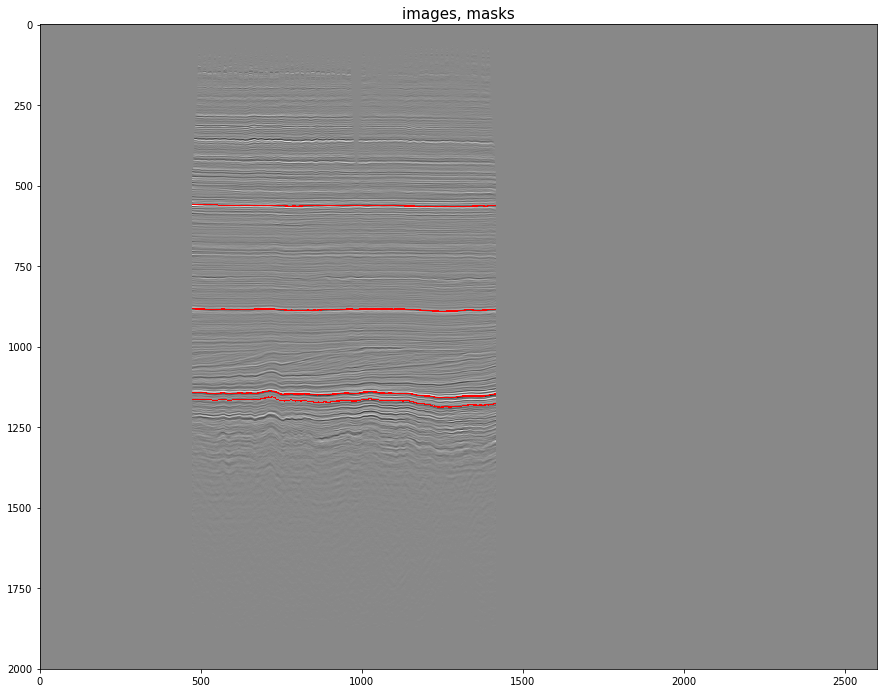

In [7]:
ds.show_slide(idx=0, n_line=700)

Again, note that there are **4 labeled horizons** that go along with the training cube. Your task is to *train a neural network to detect these 4 horizons*. Your model is to be evaluated against the validation cube. Most likely, your predictions will be represented by a predicted horizon-mask. In this case, predicted horizons will be extracted from a segmentation mask by a special procedure `get_point_cloud`, that transforms a 3d-array into a point cloud.

We highly recommend you to approach the task at hand as an improvement upon the baseline model from the next section. Good luck! 

<a id='architecture'></a>

# Training and testing baseline-model

Before thinking about a neural network architecture, let's first divide the training cube (the first part of a seismic cube) into training and testing subparts. We suggest you do the same thing and use testing part of the cube for choosing model hyperparameters later. 

In [9]:
ds.modify_sampler('train_sampler',
                  low=0.8, high=1.0,
                  finish=True)
ds.modify_sampler('test_sampler',
                  low=0.8, high=1.0,
                  finish=True)

That creates two attributes, `ds.train_sampler` and `ds.test_sampler`, which are used to sample crops from the first 80% of ilines or the last 20% of ilines respectively. That is also shown in [tutorial](./../tutorials/1.%20Cubeset.ipynb).

* setting up the architecture

For a baseline model we use convolutional neural network `UNet` and train it on crops of (256, 256, 2) size:

In [50]:
# Global constants
EPOCHS = 120
NUM_CROPS = 64
CROP_SHAPE = (2, 256, 256) # i, x, h

In [51]:
# Custom ED class is to ensure that `head` block does not `crop` its inputs.
# For more on that, check the `head` method of EncoderDecoder
class ED(EncoderDecoder):
    @classmethod
    def head(cls, inputs, targets, name='head', **kwargs):
        kwargs = cls.fill_params('head', **kwargs)

        with tf.variable_scope(name):
            x = TFModel.head(inputs, name, **kwargs)
            channels = cls.num_channels(targets)
            if cls.num_channels(x) != channels:
                args = {**kwargs, **dict(layout='c', kernel_size=1, filters=channels)}
                x = conv_block(x, name='conv1x1', **args)
                x = tf.expand_dims(x, axis=-1, name='expand')
        return x


# Model configuration
model_config = {
    # Shapes and orders
    'inputs/images/shape': (None, None, CROP_SHAPE[0]), # repeats already chosen
    'inputs/masks/shape': (None, None, CROP_SHAPE[0], 1), # repeats already chosen
    'initial_block/inputs': 'images',
    'common/data_format': 'channels_last',
    # Model layout
    'initial_block': {'layout': 'pp'},  # always conv_block (from tf model). explain layout

    'output': 'sigmoid',
    # Train configuration
    'loss': 'dice',
    'optimizer': 'Adam',
    'decay': {'name': 'invtime',
              'learning_rate': 0.01,
              'decay_rate': 1,
              'decay_steps': 100},
    'microbatch': 4,
}

pipeline_config = {
    'model': ED,
    'model_config': model_config,
}

<a id='training'></a>

* training the baseline

Before starting any real computation in `Seismiqb`, we need a plan - a *pipeline*. In the next cell we define a pipeline, that crops interesting parts of the training subpart of the cube, performs an important normalization and trains `UNet`-model.

In [76]:
train_template = (Pipeline(config=pipeline_config)
                  # Initialize pipeline variables and model
                  .init_variable('loss_history', [])
                  .init_model('dynamic', C('model'), 'ED', C('model_config'))
                  # Load data/masks
                  .load_component(src=[D('geometries'), D('labels')],
                                  dst=['geometries', 'labels'])
                  .crop(points=D('train_sampler')(NUM_CROPS),
                        shape=CROP_SHAPE)
                  .load_cubes(dst='images')
                  .create_masks(dst='masks', width=2)
                  .rotate_axes(src=['images', 'masks'])
                  .scale(mode='normalize', src='images')

                  # Training
                  .add_axis(src='masks', dst='masks')
                  .train_model('ED', 
                               fetches='loss',
                               images=B('images'),
                               masks=B('masks'),
                               save_to=V('loss_history', mode='a')))

# Add dataset to pipeline
train_pipeline = train_template << ds

Every batch contains 64 crops of (256, 256, 2) size. Model is trained for 1500 epochs by `Adam` optimizer with default parameters, [inverse-time learning rate decay](https://www.tensorflow.org/api_docs/python/tf/train/inverse_time_decay).

In [77]:
# Training loop. Allows to see progress (value of loss)
train_pipeline.run(D('size'), n_iters=EPOCHS, bar='n',
                   bar_desc=W(V('loss_history')[-1].format('Loss is: {:7.7}')))

Loss against iterations:

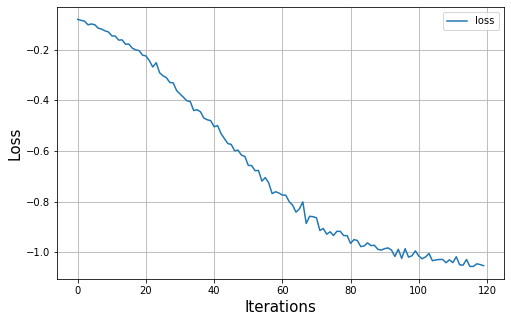

In [57]:
plot_loss(train_pipeline.v('loss_history'))

As we can see, loss starts to plateau after ~15 minutes of training. Relatively high variance suggests that model can benefit from bigger batch size.

<a id='validation'></a>

* Testing the baseline on a subpart of the first cube

Now, we want to check performance of our model on unseen part of the cubes. 

In [11]:
# Validation pipeline: no augmentations
val_template = (Pipeline()
                # Import model
                .import_model('ED', train_pipeline)
                # Load data/masks
                .load_component(src=[D('geometries'), D('labels')],
                                dst=['geometries', 'labels'])
                .crop(points=D('test_sampler')(4), shape=CROP_SHAPE)
                .load_cubes(dst='images')
                .create_masks(dst='masks')
                .rotate_axes(src=['images', 'masks'])
                .scale(mode='normalize', src='images')
                # Predict with model
                .add_axis(src='masks', dst='masks')
                .predict_model('ED', 
                               fetches='predictions',
                               images=B('images'),
                               save_to=B('predictions'))
                )
val_pipeline = val_template << ds

In [12]:
batch = val_pipeline.next_batch(D('size'), n_epochs=None)

We can just plot images of crops, hand-labeled masks and model predictions:

Image from E_anon


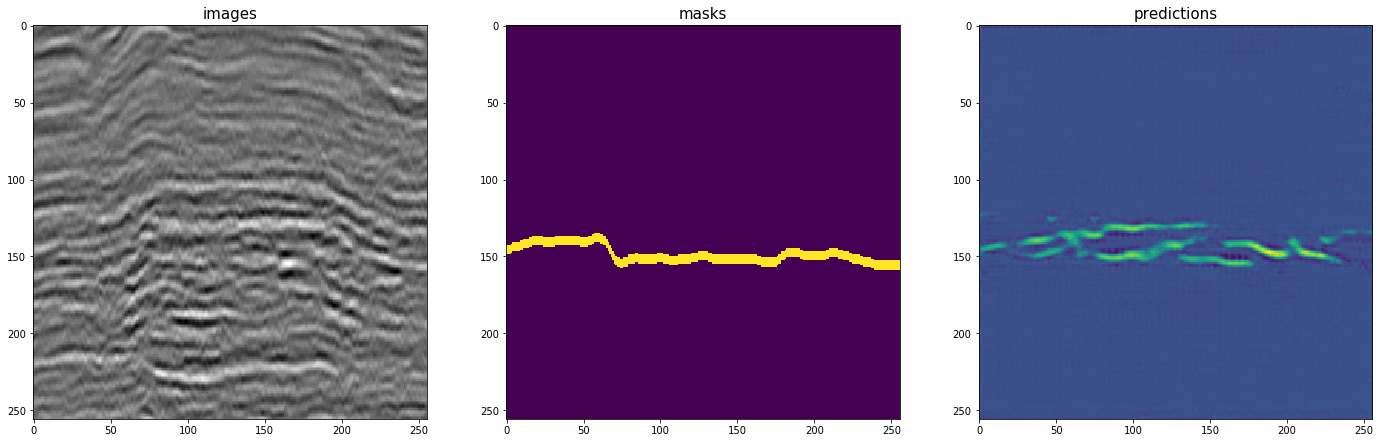

In [13]:
batch.plot_components('images', 'masks', 'predictions', overlap=False)

It is way easier to analyse results when multiple crops are aggregated back into bigger picture. Method `make_grid`, paired with action `assemble_crops`, does exactly that:

In [58]:
# Pipeline template. Can be used multiple times (for different datasets)
val_template = (Pipeline()
                .import_model('ED', train_pipeline)
                # Initialize everything
                .init_variable('result_images', init_on_each_run=[])
                .init_variable('result_preds', init_on_each_run=[])
#                 .init_model('dynamic', TFModel, 'loaded_model', load_config)     
                # Load data
                .load_component(src=D('geometries'), dst='geometries')
                .crop(points=D('grid_gen')(),
                      shape=CROP_SHAPE)
                .load_cubes(dst='images')
                .rotate_axes(src='images')
                .scale(mode='normalize', src='images')
                # Predict with model, then aggregate
                .predict_model('ED', 
                               fetches=['images', 'predictions'],
                               images=B('images'),
                               save_to=[V('result_images', mode='e'),
                                        V('result_preds', mode='e')])
                .assemble_crops(src=V('result_preds'), dst='assembled_pred',
                                  grid_info=D('grid_info'))
                .assemble_crops(src=V('result_images'), dst='assembled_img',
                                  grid_info=D('grid_info'))
                )

In [59]:
%%time
ds = ds.make_grid(ds.indices[0], CROP_SHAPE,
                  [2600, 2601], [1600, 2598], [0, 2000],
                  strides=[2, 128, 128])

val_pipeline = val_template << ds

for _ in trange(ds.grid_iters):
    batch = val_pipeline.next_batch(D('size'), n_epochs=None)


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]

CPU times: user 2.35 s, sys: 2.48 s, total: 4.83 s
Wall time: 4.36 s


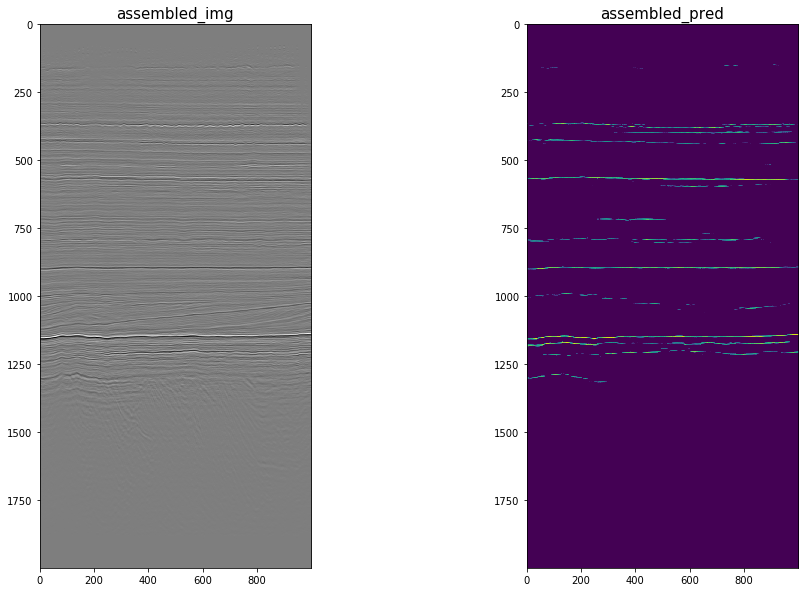

In [60]:
batch.plot_components('assembled_img', 'assembled_pred', idx=None, order_axes=(1, 2, 0), overlap=False)

fetch horizons predictions

In [61]:
_ = ds.get_point_cloud(batch.assembled_pred, 'horizons',
                       coordinates='lines', threshold=0.05)

<a id='improving'></a>

# Improving and evaluating the baseline

* hint 1

In [ ]:
                  # Augmentations
                  .additive_noise(scale=0.005,
                                  src='images', dst='images', p=0.2)
                  .rotate(angle=P(R('uniform', -30, 30)),
                          src=['images', 'masks'], p=0.4)
                  .scale_2d(scale=P(R('uniform', 0.7, 1.3)),
                            src=['images', 'masks'], p=0.4)
                  .elastic_transform(alpha=P(R('uniform', 35, 45)), sigma=P(R('uniform', 4, 4.5)),
                                     src=['images', 'masks'], p=0.2)

* hint 2

In [ ]:
    'body/encoder': {'num_stages': 3,   # 3 down, but 5 upper. explain that can choose the number of stages both up and down
                     'blocks': {'base': Inception_v4.inception_a_block, # list blocks: resnet, xception, densenet, inception(8) explain params
                                                                        # default block EncoderDecoder.block
                                'filters': [[32, 16], [48, 32], [64, 48]]}}, # help for filters but do anything wou want for f's sake
                                                                             # default are always cna; Cna; Wna;
                                                                             # filters correspond to 


* hint 3

In [ ]:
    'body/decoder': {'num_stages': 5,   # num of up stages: 3 with skip;
                     'blocks': {'layout':'cna',  # must somehow get the same output shape
                                'filters': [32, 16, 8, 6, 4]}}, # write two options of down/up-sample here

* hint 4

In [ ]:
    'body/embedding': {'base': Inception_v4.inception_c_block, # another inception block with diff params
                       'filters': [32, 48, 64, 96]},  #..with diff params(num of filters)

* fetching predictions of the resulting model on validation cube

In [10]:
paths_cubes = ['/notebooks/SEISMIC_DATA/CUBE_3/P_cube.hdf5']
test_dsi = FilesIndex(path=paths_cubes, no_ext=True)
test_ds = SeismicCubeset(dsi)

In [ ]:
test_ds = test_ds.make_grid(test_ds.indices[0], CROP_SHAPE, ...)

val_pipeline = val_template << test_ds

for _ in trange(test_ds.grid_iters):
    batch = val_pipeline.next_batch(D('size'), n_epochs=None)